# Distributions normalized to number of pixels with the FWI value

In [1]:
# ---------------------------------------------------------------------------------------------
# MODULES
# ---------------------------------------------------------------------------------------------
import os
import seaborn as sns
import pandas as pd
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as dcopy
from pandas.api.types import CategoricalDtype
from matplotlib.lines import Line2D

In [2]:
# ---------------------------------------------------------------------------------------------
# SET DETAILS FIGURES
# ---------------------------------------------------------------------------------------------
font_title = 20
font_subtitle = 16
font_axes = 14
font_ticklabels = 12
font_text = 12
font_legend = 12

In [3]:
# ---------------------------------------------------------------------------------------------
# SPECIFY TIER AND CORRESPONDING PATHS
# ---------------------------------------------------------------------------------------------
Tier = 'Hortense'

if Tier == 'Hortense':
    path_ref = '/dodrio/scratch/projects/2022_200/project_output/rsda/vsc33651/PEATBURN/Tropical/Reference'
    path_out = '/dodrio/scratch/projects/2022_200/project_output/rsda/vsc33651/PEATBURN/Tropical/output/CDF_matched'
    path_fires = '/dodrio/scratch/projects/2022_200/project_output/rsda/vsc33651/PEATBURN/Tropical/Fire_data'
    path_figs = '/dodrio/scratch/projects/2022_200/project_output/rsda/vsc33651/PEATBURN/Tropical/output/Figures'
    path_peatlands = '/dodrio/scratch/projects/2022_200/project_output/rsda/vsc33651/PEATBURN/Tropical/PEATCLSM'
    path_PEATMAP = '/dodrio/scratch/projects/2022_200/project_output/rsda/vsc33651/PEATBURN/Tropical/PEATMAP' \
                   '/Miettinen2016-PeatLCC900715'

elif Tier == 'Genius':
    path_ref = '/staging/leuven/stg_00024/OUTPUT/jonasm/PEATBURN/Tropical/Reference'
    path_out = '/staging/leuven/stg_00024/OUTPUT/jonasm/PEATBURN/Tropical/output/CDF_matched'
    path_fires = '/staging/leuven/stg_00024/OUTPUT/jonasm/PEATBURN/Tropical/Fire_data'
    path_figs = '/staging/leuven/stg_00024/OUTPUT/jonasm/PEATBURN/Tropical/output/Figures'
    path_peatlands = '/staging/leuven/stg_00024/OUTPUT/jonasm/PEATBURN/Tropical/PEATCLSM'
    path_PEATMAP = '/staging/leuven/stg_00024/OUTPUT/jonasm/PEATBURN/Tropical/PEATMAP' \
                   '/Miettinen2016-PeatLCC900715'

else:
    print('Error: Tier can only be Hortense or Genius.')

peatland_types = ['TN', 'TD']
CDF_types = ['pixel']

In [4]:
# ---------------------------------------------------------------------------------------------
# LOAD THE FIRE DATASETS FROM THE HITS AND MISSES
# ---------------------------------------------------------------------------------------------
# Load the drained file from the hits and misses
fires_dra_file = os.path.join(path_fires, 'Table_Drapixel.csv')

fires_dra = pd.read_csv(fires_dra_file, header=0)
fires_dra['start_date'] = pd.to_datetime(fires_dra['start_date'])
# only get those fires that are in our domain and in peatclsm pixels:
fire_dra_data = fires_dra[fires_dra['Drained_I'] >= 0].reset_index(drop=True)

times = pd.date_range('2002-01-01', '2018-12-31', freq='D')

fire_dra_dates2 = pd.DatetimeIndex(fire_dra_data.start_date)
fire_dra_data = fire_dra_data[fire_dra_dates2.year >= 2002].reset_index(drop=True)

# Load the natural file from the hits and misses
fires_nat_file = os.path.join(path_fires, 'Table_Natpixel.csv')

fires_nat = pd.read_csv(fires_nat_file, header=0)
fires_nat['start_date'] = pd.to_datetime(fires_nat['start_date'])
# only get those fires that are in our domain and in peatclsm pixels:
fire_nat_data = fires_nat[fires_nat['Drained_I'] >= 0].reset_index(drop=True)

fire_nat_dates2 = pd.DatetimeIndex(fire_nat_data.start_date)
fire_nat_data = fire_nat_data[fire_nat_dates2.year >= 2002].reset_index(drop=True)

In [5]:
# ---------------------------------------------------------------------------------------------
# LOAD FWI DATASETS
# ---------------------------------------------------------------------------------------------
## Natural
# Reference:
ds_ref_nat = Dataset(os.path.join(path_ref, 'FWI_masked_Nat.nc'), 'r')
FWI_M2_nat = ds_ref_nat['MERRA2_FWI'][0:6209, :, :].data
DC_raw_nat = ds_ref_nat['MERRA2_DC'][0:6209, :, :].data  # The non-CDF-matched DC

# EXP3b:
ds_EXP3b_nat = Dataset(os.path.join(path_out, 'FWI_zbar_FFMC_TN_pixel.nc'), 'r')
FWI_EXP3b_nat = ds_EXP3b_nat['MERRA2_FWI'][0:6209, :, :].data

## Drained
# Reference:
ds_ref_dra = Dataset(os.path.join(path_ref, 'FWI_masked_Dra.nc'), 'r')
FWI_M2_dra = ds_ref_dra['MERRA2_FWI'][0:6209, :, :].data
DC_raw_dra = ds_ref_dra['MERRA2_DC'][0:6209, :, :].data  # The non-CDF-matched DC

# EXP3b:
ds_EXP3b_dra = Dataset(os.path.join(path_out, 'FWI_zbar_FFMC_TD_pixel.nc'), 'r')
FWI_EXP3b_dra = ds_EXP3b_dra['MERRA2_FWI'][0:6209, :, :].data

## Define functions

In [6]:
def fill_raster_from_df(fire_data, latitudes, longitudes, time_ref, raster_shape):
    """
    Fills a raster based on the contents of a DataFrame with fire data.

    Parameters:
    fire_data (pd.DataFrame): DataFrame containing fire data with columns 'start_date', 'end_date', 'latitude_I', 'longitude_I'.
    latitudes (np.array): Array of latitude values for the raster.
    longitudes (np.array): Array of longitude values for the raster.
    time_ref (str): Reference date in 'YYYY-MM-DD' format for time calculations.
    raster_shape (tuple): Shape of the raster (time_dim, lat_dim, lon_dim).

    Returns:
    np.array: Raster filled with fire data.
    """
    # Extract dimensions from raster_shape
    dim_time, dim_lat, dim_lon = raster_shape

    # Initialize the raster
    fire_raster = np.zeros((dim_time, dim_lat, dim_lon))

    # Convert reference time to datetime
    ref_time = pd.to_datetime(time_ref)

    # Loop over each fire entry in the DataFrame
    for idx, row in fire_data.iterrows():
        # Convert start and end dates to days since reference date
        time_start = (pd.to_datetime(row['start_date']) - ref_time).days

        latitude = row['latitude_P']
        longitude = row['longitude_P']
        
        # Compute latitude and longitude differences
        lat_diffs = np.abs(latitudes - latitude)
        lon_diffs = np.abs(longitudes - longitude)

        # Find nearest indices for latitude and longitude
        lat_index = np.argmin(lat_diffs)
        lon_index = np.argmin(lon_diffs)


        fire_raster[time_start, lat_index, lon_index] += 1

    return fire_raster

# Example usage:
# Assume you have loaded these arrays and DataFrames
lats = ds_ref_nat['lat'][:]
lons = ds_ref_nat['lon'][:]

# Define raster shapes
raster_shape_nat = (FWI_M2_nat.shape[0], FWI_M2_nat.shape[1], FWI_M2_nat.shape[2])
raster_shape_dra = (FWI_M2_dra.shape[0], FWI_M2_dra.shape[1], FWI_M2_dra.shape[2])

# Fill raster with fire data
fires_raster_nat = fill_raster_from_df(fire_nat_data, lats, lons, '2002-01-01', raster_shape_nat)
fires_raster_dra = fill_raster_from_df(fire_dra_data, lats, lons, '2002-01-01', raster_shape_dra)

## Convert raster to dataframe

In [7]:
# fire_nat_data = pd.DataFrame(columns=['Fires', 'FWI_M2', 'FWI_EXP3b', 'DC_raw'])
# fire_dra_data = pd.DataFrame(columns=['Fires', 'FWI_M2', 'FWI_EXP3b', 'DC_raw'])

In [8]:
# fire_nat_data['Fires'] = fires_raster_nat.flatten()
# fire_nat_data['FWI_M2'] = FWI_M2_nat.flatten()
# fire_nat_data['FWI_EXP3b'] = FWI_EXP3b_nat.flatten()
# # fire_nat_data['DC_raw'] = DC_raw_nat.flatten()

# fire_dra_data['Fires'] = fires_raster_dra.flatten()
# fire_dra_data['FWI_M2'] = FWI_M2_dra.flatten()
# fire_dra_data['FWI_EXP3b'] = FWI_EXP3b_dra.flatten()
# fire_dra_data['DC_raw'] = DC_raw_dra.flatten()

## Take the log() of FWI

In [9]:
# fire_nat_data['FWI_M2_log'] = np.log10(fire_nat_data['FWI_M2'])
# fire_nat_data['FWI_EXP3b_log'] = np.log10(fire_nat_data['FWI_EXP3b'])
# # fire_nat_data['DC_raw_log'] = np.log10(fire_nat_data['DC_raw'])

# fire_dra_data['FWI_M2_log'] = np.log10(fire_dra_data['FWI_M2'])
# fire_dra_data['FWI_EXP3b_log'] = np.log10(fire_dra_data['FWI_EXP3b'])
# # fire_dra_data['DC_raw_log'] = np.log10(fire_dra_data['DC_raw'])

## Only take the rows with a fire for plots a and b

In [10]:
# fire_nat_data_fires = fire_nat_data[fire_nat_data.Fires > 0]
# fire_dra_data_fires = fire_dra_data[fire_dra_data.Fires > 0]

## Now with binary fire data (set all grid cells in the fire rasters >1 to 1) and predefined bins

In [11]:
nat_bin = dcopy(fires_raster_nat)
dra_bin = dcopy(fires_raster_dra)

In [12]:
nat_bin[nat_bin > 1] = 1
dra_bin[dra_bin > 1] = 1

## Convert raster again to dataframe

In [13]:
df_nat_bin = pd.DataFrame(columns=['Fires', 'FWI_M2', 'FWI_EXP3b', 'DC_raw'])
df_dra_bin = pd.DataFrame(columns=['Fires', 'FWI_M2', 'FWI_EXP3b', 'DC_raw'])

In [14]:
df_nat_bin['Fires'] = nat_bin.flatten()
df_nat_bin['FWI_M2'] = FWI_M2_nat.flatten()
df_nat_bin['FWI_EXP3b'] = FWI_EXP3b_nat.flatten()
# df_nat_bin['DC_raw'] = DC_raw_nat.flatten()

df_dra_bin['Fires'] = dra_bin.flatten()
df_dra_bin['FWI_M2'] = FWI_M2_dra.flatten()
df_dra_bin['FWI_EXP3b'] = FWI_EXP3b_dra.flatten()
# df_dra_bin['DC_raw'] = DC_raw_dra.flatten()

In [15]:
df_nat_bin['FWI_M2_log'] = np.log10(df_nat_bin['FWI_M2'])
df_nat_bin['FWI_EXP3b_log'] = np.log10(df_nat_bin['FWI_EXP3b'])
# df_nat_bin['DC_raw_log'] = np.log10(df_nat_bin['DC_raw'])

df_dra_bin['FWI_M2_log'] = np.log10(df_dra_bin['FWI_M2'])
df_dra_bin['FWI_EXP3b_log'] = np.log10(df_dra_bin['FWI_EXP3b'])
# df_dra_bin['DC_raw_log'] = np.log10(df_dra_bin['DC_raw'])

## Define bins

In [16]:
# Define bins and ranges once
bins = 50

bins_nat = np.linspace(np.nanmin([df_nat_bin.FWI_M2_log, df_nat_bin.FWI_EXP3b_log]), 
                       np.nanmax([df_nat_bin.FWI_M2_log, df_nat_bin.FWI_EXP3b_log]), bins)
bins_dra = np.linspace(np.nanmin([df_dra_bin.FWI_M2_log, df_dra_bin.FWI_EXP3b_log]), 
                       np.nanmax([df_dra_bin.FWI_M2_log, df_dra_bin.FWI_EXP3b_log]), bins)

binrange_nat = [np.nanmin(bins_nat), np.nanmax(bins_nat)]
binrange_dra = [np.nanmin(bins_dra), np.nanmax(bins_dra)]

# bins_nat_DC = np.linspace(np.nanmin(df_nat_bin.DC_raw_log), np.nanmax(df_nat_bin.DC_raw_log), bins)
# bins_dra_DC = np.linspace(np.nanmin(df_dra_bin.DC_raw_log), np.nanmax(df_dra_bin.DC_raw_log), bins)

# binrange_nat_DC = [np.nanmin(bins_nat_DC), np.nanmax(bins_nat_DC)]
# binrange_dra_DC = [np.nanmin(bins_dra_DC), np.nanmax(bins_dra_DC)]

## Then add bins to dataframe and make sure each row is assigned a bin

In [17]:
df_nat_bin['bin_M2'] = pd.cut(df_nat_bin['FWI_M2_log'], bins=bins_nat, labels=False, right=False)
df_nat_bin['bin_EXP3b'] = pd.cut(df_nat_bin['FWI_EXP3b_log'], bins=bins_nat, labels=False, right=False)
df_dra_bin['bin_M2'] = pd.cut(df_dra_bin['FWI_M2_log'], bins=bins_dra, labels=False, right=False)
df_dra_bin['bin_EXP3b'] = pd.cut(df_dra_bin['FWI_EXP3b_log'], bins=bins_dra, labels=False, right=False)

# df_nat_bin['bin_DC'] = pd.cut(df_nat_bin['DC_raw_log'], bins=bins_nat_DC, labels=False, right=False)
# df_dra_bin['bin_DC'] = pd.cut(df_dra_bin['DC_raw_log'], bins=bins_dra_DC, labels=False, right=False)

In [18]:
rows_per_bin_M2_nat = df_nat_bin.groupby('bin_M2').size().reset_index(name='total_rows_M2')
rows_per_bin_EXP3b_nat = df_nat_bin.groupby('bin_EXP3b').size().reset_index(name='total_rows_EXP3b')
rows_per_bin_M2_dra = df_dra_bin.groupby('bin_M2').size().reset_index(name='total_rows_M2')
rows_per_bin_EXP3b_dra = df_dra_bin.groupby('bin_EXP3b').size().reset_index(name='total_rows_EXP3b')

# rows_per_bin_DC_nat = df_nat_bin.groupby('bin_DC').size().reset_index(name='total_rows_DC')
# rows_per_bin_DC_dra = df_dra_bin.groupby('bin_DC').size().reset_index(name='total_rows_DC')

In [19]:
df_nat_bin = df_nat_bin.merge(rows_per_bin_M2_nat, on='bin_M2', how='left')
df_nat_bin = df_nat_bin.merge(rows_per_bin_EXP3b_nat, on='bin_EXP3b', how='left')

df_dra_bin = df_dra_bin.merge(rows_per_bin_M2_dra, on='bin_M2', how='left')
df_dra_bin = df_dra_bin.merge(rows_per_bin_EXP3b_dra, on='bin_EXP3b', how='left')

# df_nat_bin = df_nat_bin.merge(rows_per_bin_DC_nat, on='bin_DC', how='left')
# df_dra_bin = df_dra_bin.merge(rows_per_bin_DC_dra, on='bin_DC', how='left')

In [20]:
df_nat_bin['normalized_fires_M2'] = df_nat_bin['Fires'] / df_nat_bin['total_rows_M2']
df_nat_bin['normalized_fires_EXP3b'] = df_nat_bin['Fires'] / df_nat_bin['total_rows_EXP3b']
df_dra_bin['normalized_fires_M2'] = df_dra_bin['Fires'] / df_dra_bin['total_rows_M2']
df_dra_bin['normalized_fires_EXP3b'] = df_dra_bin['Fires'] / df_dra_bin['total_rows_EXP3b']

# df_nat_bin['normalized_fires_DC'] = df_nat_bin['Fires'] / df_nat_bin['total_rows_DC']
# df_dra_bin['normalized_fires_DC'] = df_dra_bin['Fires'] / df_dra_bin['total_rows_DC']

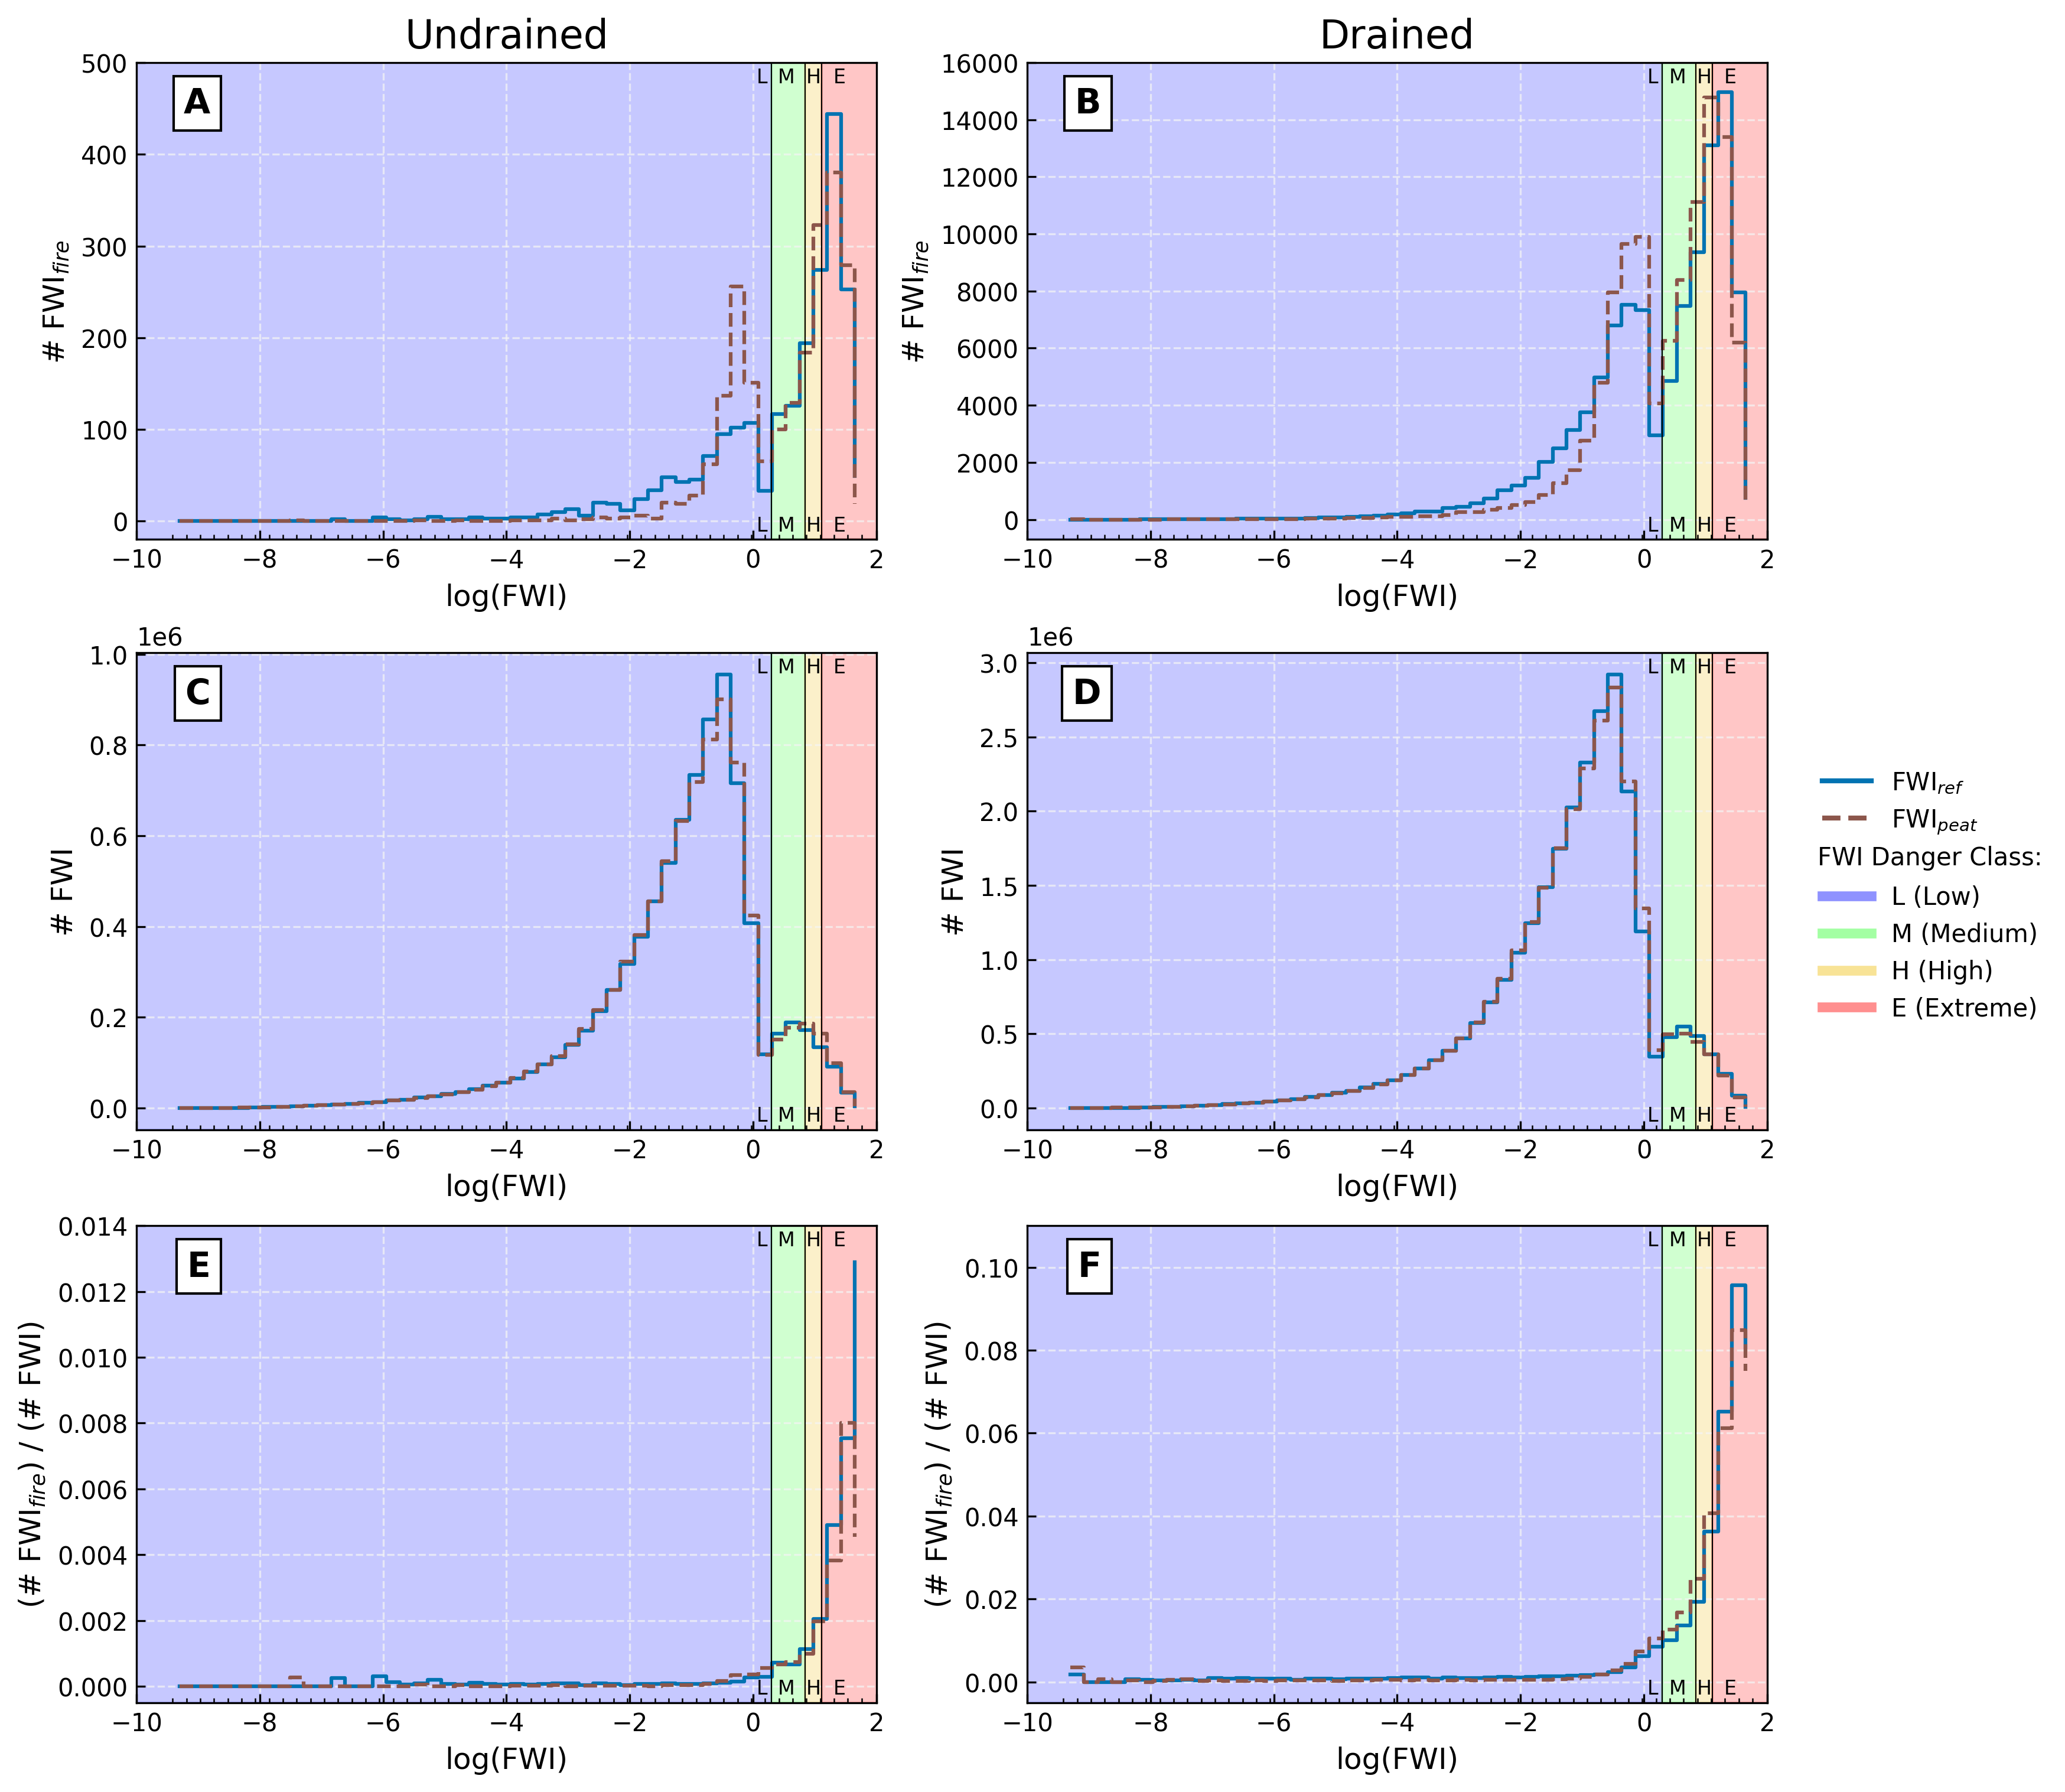

In [21]:
# colorblind proof:
palette = sns.color_palette('colorblind')

color_ref = palette[0]
color_exp = 'tab:brown'
ls_exp = '--'

# Precompute the histogram data to avoid redoing it in each sns.histplot call
def precompute_hist_data(data, column, bins, binrange, weights_column=None):
    if weights_column is not None:
        hist, bin_edges = np.histogram(data[column], bins=bins, range=binrange, weights=data[weights_column])
    else:
        hist, bin_edges = np.histogram(data[column], bins=bins, range=binrange)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return hist, bin_centers, bin_edges

# Precompute histograms for all datasets
datasets = [('FWI_M2_log', 'Fires', color_ref, 'solid'),
                ('FWI_EXP3b_log', 'Fires', color_exp, ls_exp)]

# datasets_dra = [('FWI_M2_log', 'Fires', color_ref, 'solid'),
#                 ('FWI_EXP3b_log', 'Fires', color_exp, ls_exp)]

fig = plt.figure(layout='constrained', figsize=(10,10), dpi=300)
ax = fig.subplot_mosaic(
    """
    AB
    CD
    EF
    """
)

# Plot histograms for fire_nat_data_fires and fire_dra_data_fires
# for i, dataset in enumerate([df_nat_bin, df_dra_bin]):
#     for j, (col, weight, color, ls) in enumerate(datasets_nat if i == 0 else datasets_dra):
#         hist_data, bin_centers = precompute_hist_data(dataset, col, bins, binrange_nat if i == 0 else binrange_dra, weight)
#         key = 'A' if i == 0 else 'B'  # Choose subplot key based on the layout (A for nat, B for dra)
#         ax[key].plot(bin_centers, hist_data, color=color, ls=ls)

# Plot histograms for fire_nat_data_fires and fire_dra_data_fires
for i, dataset in enumerate([df_nat_bin, df_dra_bin]):
    for j, (col, weight, color, ls) in enumerate(datasets):
        hist_data, bin_centers, bin_edges = precompute_hist_data(dataset, col, bins, binrange_nat if i == 0 else binrange_dra, weight)
        key = 'A' if i == 0 else 'B'  # Choose subplot key based on the layout (A for nat, B for dra)
        ax[key].plot(bin_centers, hist_data, color=color, ls=ls, drawstyle='steps-post')  # Use 'steps-post' for step plots
        ax[key].set_xticks(bin_edges, minor=True)

# Similarly for df_nat_bin and df_dra_bin
for i, dataset in enumerate([df_nat_bin, df_dra_bin]):
    for j, (col, weight, color, ls) in enumerate(datasets):
        hist_data, bin_centers, bin_edges = precompute_hist_data(dataset, col, bins, binrange_nat if i == 0 else binrange_dra)
        key = 'C' if i == 0 else 'D'
        ax[key].plot(bin_centers, hist_data, color=color, ls=ls, drawstyle='steps-post')
        ax[key].set_xticks(bin_edges, minor=True)

# Normalized fire histograms
datasets_norm = [('FWI_M2_log', 'normalized_fires_M2', color_ref, 'solid'), 
                 ('FWI_EXP3b_log', 'normalized_fires_EXP3b', color_exp, ls_exp)]

# for i, dataset in enumerate([df_nat_bin, df_dra_bin]):
#     for j, (col, weight, color, ls) in enumerate(datasets_norm):
#         hist_data, bin_centers, bin_edges = precompute_hist_data(dataset, col, bins, binrange_nat if i == 0 else binrange_dra, weight)
#         print(bin_centers[-1])
#         print(hist_data[-1])
#         key = 'E' if i == 0 else 'F'
#         ax[key].plot(bin_centers, hist_data, color=color, ls=ls, drawstyle='steps-post')
#         ax[key].set_xticks(bin_edges, minor=True)

for i, dataset in enumerate([df_nat_bin, df_dra_bin]):
    for j, (col, weight, color, ls) in enumerate(datasets):
        hist_data_w, bin_centers_w, bin_edges_w = precompute_hist_data(dataset, col, bins, binrange_nat if i == 0 else binrange_dra, weight)
        hist_data, bin_centers, bin_edges = precompute_hist_data(dataset, col, bins, binrange_nat if i == 0 else binrange_dra)
        key = 'E' if i == 0 else 'F'
        ax[key].plot(bin_centers, (hist_data_w / hist_data), color=color, ls=ls, drawstyle='steps-post')
        ax[key].set_xticks(bin_edges, minor=True)


        
# Add vertical shading regions
shading_regions = [
    (np.log10(0.0000000000001), np.log10(2), '#8F92FF'),   # From x=0 to x=2
    (np.log10(2), np.log10(7), '#A3FFA3'),   # From x=2 to x=7
    (np.log10(7), np.log10(13), '#F8E396'),  # From x=7 to x=13
    (np.log10(13), np.log10(1000), '#FF8F8F')  # From x=13 to infinity
]

# Apply shading for each subplot
for label, axis in ax.items():
    for (xmin, xmax, color) in shading_regions:
        axis.axvspan(xmin, xmax, color=color, alpha=0.5)

# Add titles etc to the plot
titles = {
    'A': 'Undrained',
    'B': 'Drained',
    'C': '',
    'D': '',
    'E': '',
    'F': ''
}

xlabels = {
    'A': 'log(FWI)',
    'B': 'log(FWI)',
    'C': 'log(FWI)',
    'D': 'log(FWI)',
    'E': 'log(FWI)',
    'F': 'log(FWI)'
}

ylabels = {
    'A': '# FWI$_{fire}$',
    'B': '# FWI$_{fire}$',
    'C': '# FWI',
    'D': '# FWI',
    'E': '(# FWI$_{fire}$) / (# FWI)',
    'F': '(# FWI$_{fire}$) / (# FWI)'
}

for label, axis in ax.items():
    axis.annotate(f'{label}', xy=(0.1, 0.95), xycoords='axes fraction', fontsize=14, weight='bold', ha='right', va='top', 
                  bbox=dict(facecolor='white', edgecolor='black', boxstyle='square', pad=0.3))
    axis.grid(True, which='major', linestyle='--', color='whitesmoke', alpha=0.7)
    axis.tick_params(axis='both', which='both', direction='in')
    axis.set_title(titles[label], fontsize=16)
    axis.set_xlabel(xlabels[label], fontsize=12)
    axis.set_ylabel(ylabels[label], fontsize=12)

    if label in ['A', 'C', 'E']:
        axis.set_xlim(-10,2)
        if label == 'A':
            axis.set_ylim(-20,500)
        if label == 'E':
            axis.set_ylim(-0.0005,0.014)

        # Add a letter indicating the fire danger class to the figures
        ## Add indications on top
        # axis.annotate('L', xy=(0.815, 0.99), xycoords='axes fraction', fontsize=8, ha='center', va='top')
        # axis.annotate('M', xy=(0.87, 0.99), xycoords='axes fraction', fontsize=8, ha='right', va='top')
        # axis.annotate('H', xy=(0.8975, 0.99), xycoords='axes fraction', fontsize=8, ha='center', va='top')
        # axis.annotate('E', xy=(0.925, 0.99), xycoords='axes fraction', fontsize=8, ha='center', va='top')
        # # and bottom
        # axis.annotate('L', xy=(0.815, 0.05), xycoords='axes fraction', fontsize=8, ha='center', va='top')
        # axis.annotate('M', xy=(0.87, 0.05), xycoords='axes fraction', fontsize=8, ha='right', va='top')
        # axis.annotate('H', xy=(0.8975, 0.05), xycoords='axes fraction', fontsize=8, ha='center', va='top')
        # axis.annotate('E', xy=(0.925, 0.05), xycoords='axes fraction', fontsize=8, ha='center', va='top')
        # Add lines
        # axis.axvline(x=np.log10(2), linewidth=0.5, color='k')
        # axis.axvline(x=np.log10(7), linewidth=0.5, color='k')
        # axis.axvline(x=np.log10(13), linewidth=0.5, color='k')
                
    elif label in ['B', 'D', 'F']:
        axis.set_xlim(-10,2)
        if label == 'B':
            axis.set_ylim(-700,16000)      
        if label == 'F':
            axis.set_ylim(-0.005,0.11)

    # Add a letter indicating the fire danger class to the figures
    ## Add indications on top
    axis.annotate('L', xy=(0.845, 0.99), xycoords='axes fraction', fontsize=8, ha='center', va='top')
    axis.annotate('M', xy=(0.89, 0.99), xycoords='axes fraction', fontsize=8, ha='right', va='top')
    axis.annotate('H', xy=(0.915, 0.99), xycoords='axes fraction', fontsize=8, ha='center', va='top')
    axis.annotate('E', xy=(0.95, 0.99), xycoords='axes fraction', fontsize=8, ha='center', va='top')
    # and bottom
    axis.annotate('L', xy=(0.845, 0.05), xycoords='axes fraction', fontsize=8, ha='center', va='top')
    axis.annotate('M', xy=(0.89, 0.05), xycoords='axes fraction', fontsize=8, ha='right', va='top')
    axis.annotate('H', xy=(0.915, 0.05), xycoords='axes fraction', fontsize=8, ha='center', va='top')
    axis.annotate('E', xy=(0.95, 0.05), xycoords='axes fraction', fontsize=8, ha='center', va='top')
    # Add lines
    axis.axvline(x=np.log10(2), linewidth=0.5, color='k')
    axis.axvline(x=np.log10(7), linewidth=0.5, color='k')
    axis.axvline(x=np.log10(13), linewidth=0.5, color='k')

# Creating custom legend for histograms and danger classes
legend_elements = [
    Line2D([0], [0], color=color_ref, lw=2, label='FWI$_{ref}$'),
    Line2D([0], [0], color=color_exp, lw=2, ls=ls_exp, label='FWI$_{peat}$'),
    # Line2D([0], [0], color='tab:red', lw=2, label='DC$_{ref}$'),
    Line2D([0], [0], color='white', lw=4, label=' ', alpha=0),
    Line2D([0], [0], color='#8F92FF', lw=4, label='L (Low)'),
    Line2D([0], [0], color='#A3FFA3', lw=4, label='M (Medium)'),
    Line2D([0], [0], color='#F8E396', lw=4, label='H (High)'),
    Line2D([0], [0], color='#FF8F8F', lw=4, label='E (Extreme)'),
]

# Adding the legend to the right of the figure
fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1, frameon=False)

# Adding a subtitle for the FWI danger classes
fig.text(1.02, 0.5175, 'FWI Danger Class:', ha='left', fontsize=10, zorder=4)

plt.savefig(os.path.join(path_figs, 'Distributions_log_normalized'))

NameError: name 'binrange_nat_DC' is not defined

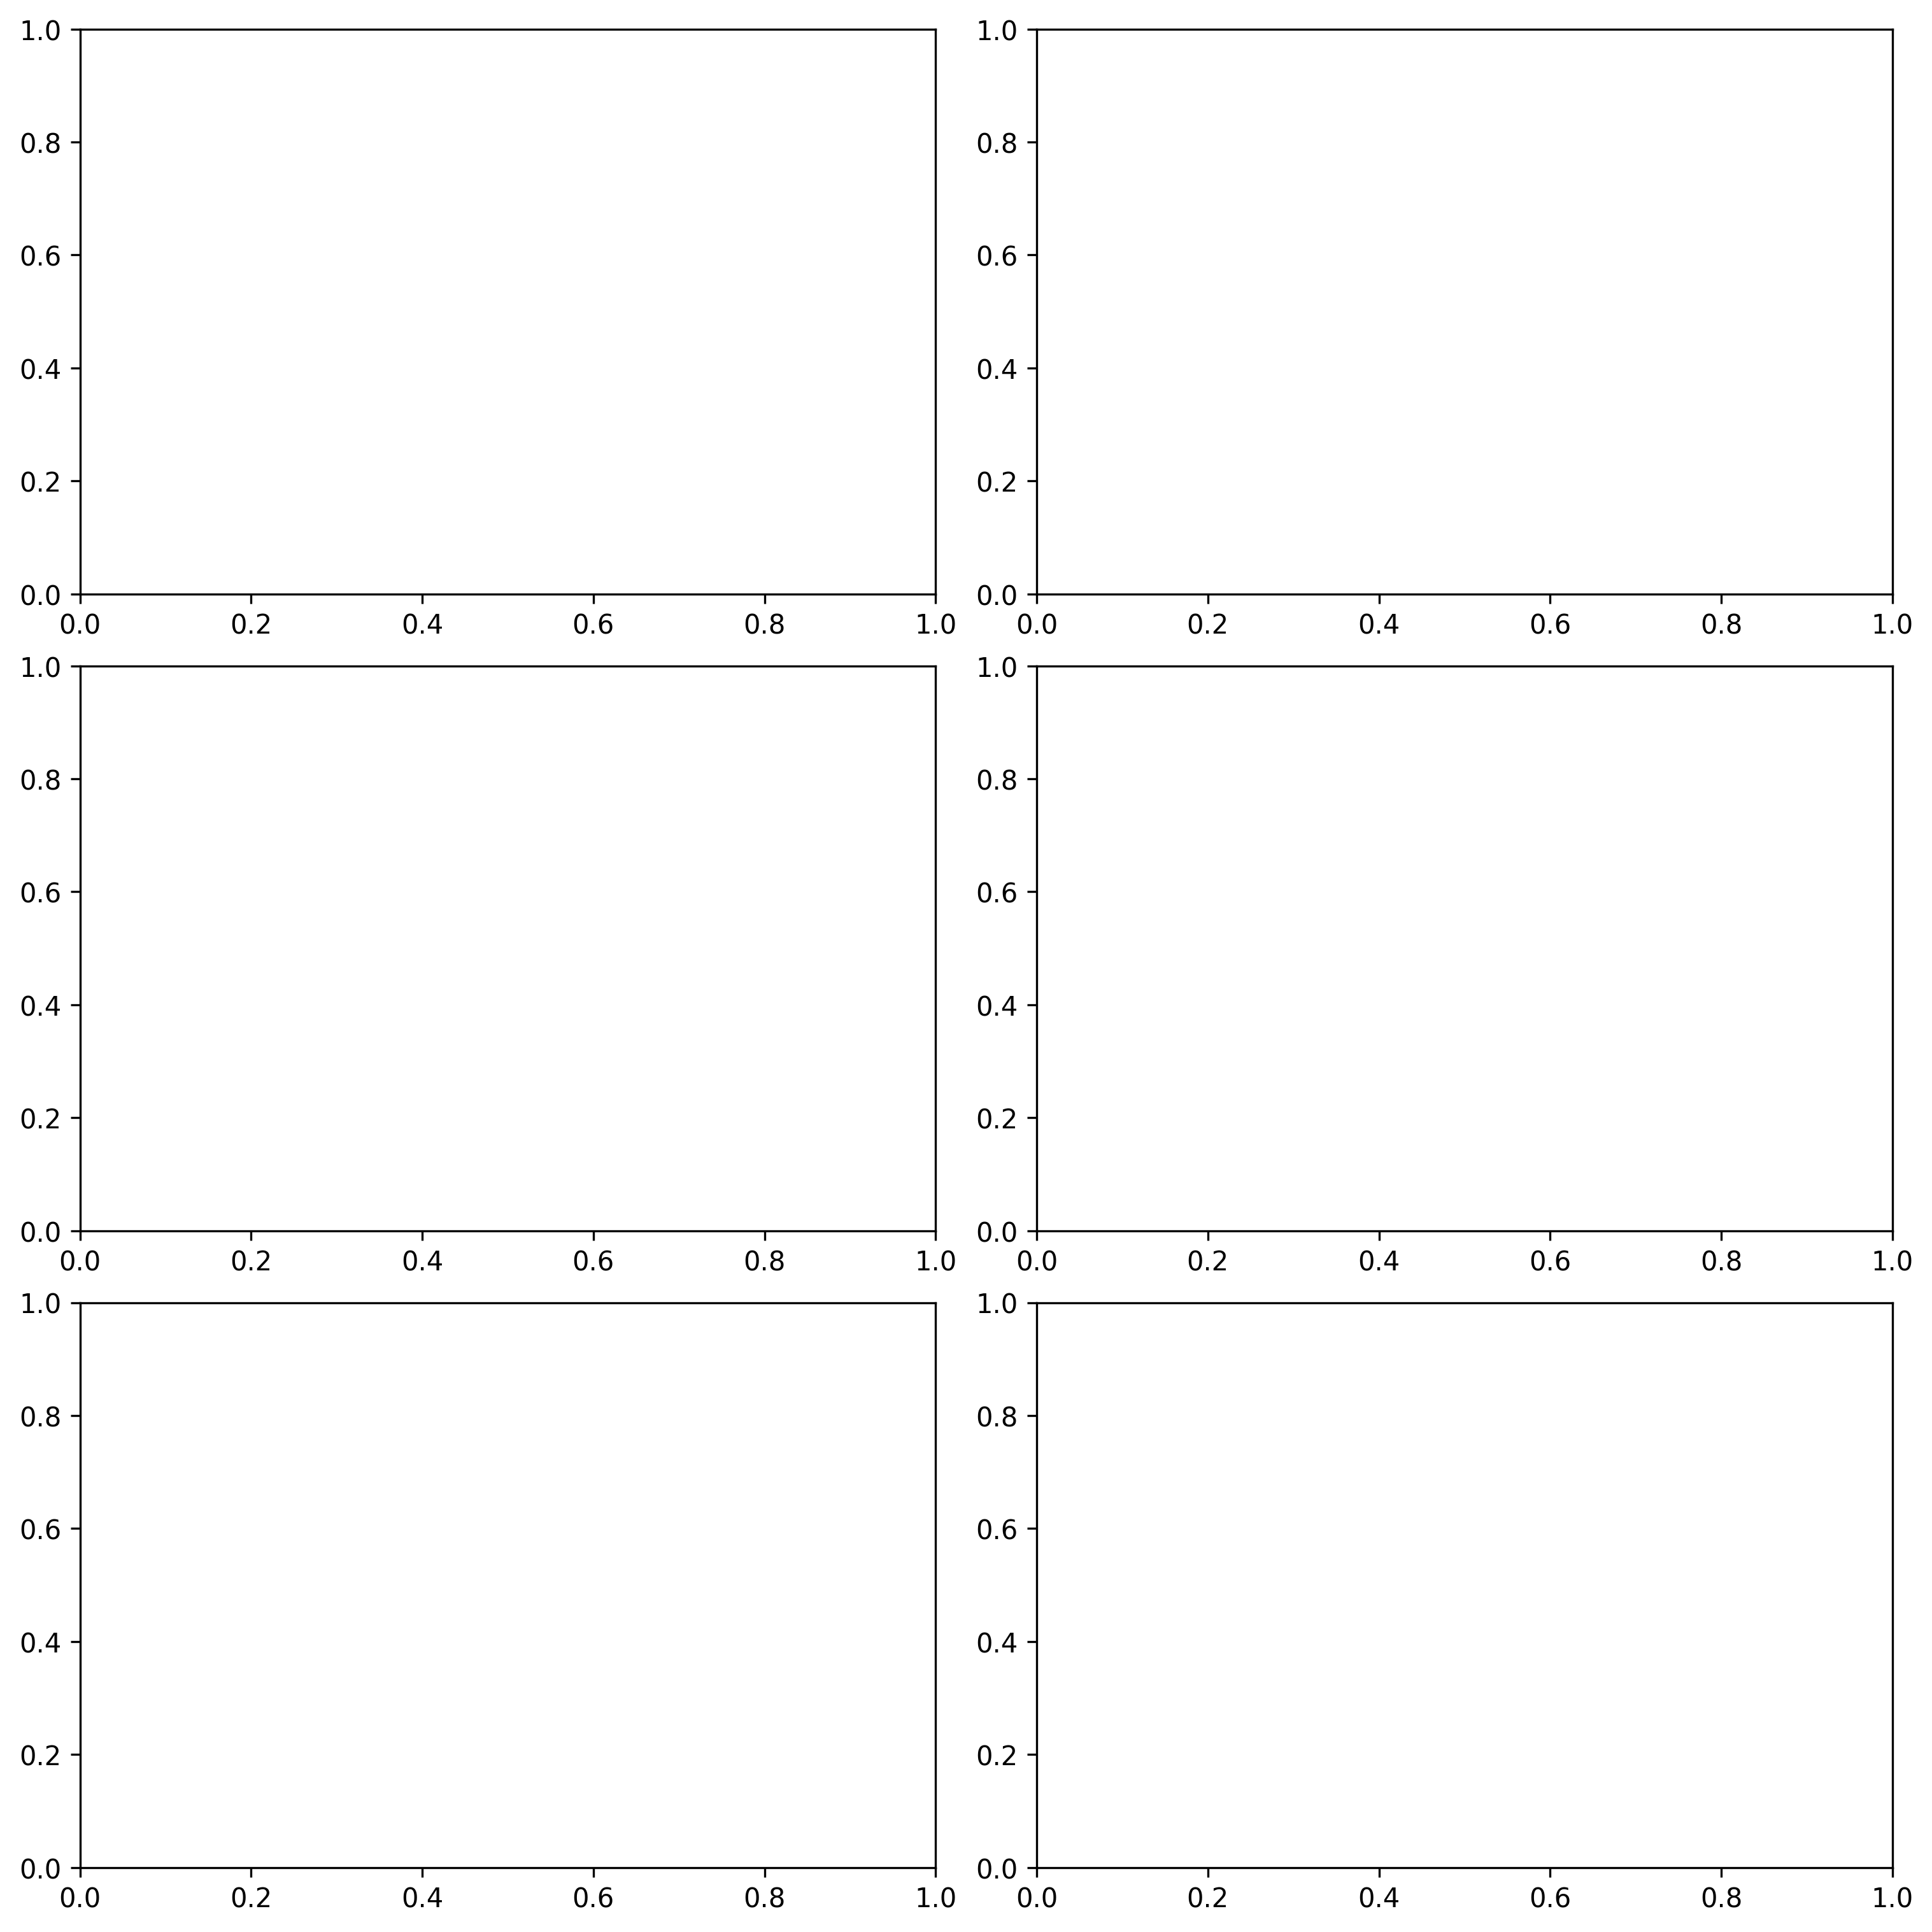

In [22]:
# Precompute the histogram data to avoid redoing it in each sns.histplot call
def precompute_hist_data(data, column, bins, binrange, weights_column=None):
    if weights_column is not None:
        hist, bin_edges = np.histogram(data[column], bins=bins, range=binrange, weights=data[weights_column])
    else:
        hist, bin_edges = np.histogram(data[column], bins=bins, range=binrange)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return hist, bin_centers, bin_edges

# Precompute histograms for all datasets
datasets = [('DC_raw_log', 'Fires', 'tab:red', 'solid')]

fig = plt.figure(layout='constrained', figsize=(10,10), dpi=300)
ax = fig.subplot_mosaic(
    """
    AB
    CD
    EF
    """
)

# Plot histograms for fire_nat_data_fires and fire_dra_data_fires
for i, dataset in enumerate([df_nat_bin, df_nat_bin]):
    for j, (col, weight, color, ls) in enumerate(datasets):
        hist_data, bin_centers, bin_edges = precompute_hist_data(dataset, col, bins, binrange_nat_DC if i == 0 else binrange_dra_DC, weight)
        key = 'A' if i == 0 else 'B'  # Choose subplot key based on the layout (A for nat, B for dra)
        ax[key].plot(bin_centers, hist_data, color=color, ls=ls, drawstyle='steps-post')
        ax[key].set_xticks(bin_edges, minor=True)

# Similarly for df_nat_bin and df_dra_bin
for i, dataset in enumerate([df_nat_bin, df_dra_bin]):
    for j, (col, weight, color, ls) in enumerate(datasets):
        hist_data, bin_centers, bin_edges = precompute_hist_data(dataset, col, bins, binrange_nat_DC if i == 0 else binrange_dra_DC)
        key = 'C' if i == 0 else 'D'
        ax[key].plot(bin_centers, hist_data, color=color, ls=ls, drawstyle='steps-post')
        ax[key].set_xticks(bin_edges, minor=True)

# Normalized fire histograms
# datasets_norm = [('DC_raw_log', 'normalized_fires_DC', 'tab:red', 'solid')]

for i, dataset in enumerate([df_nat_bin, df_dra_bin]):
    for j, (col, weight, color, ls) in enumerate(datasets):
        hist_data_w, bin_centers_w, bind_edges_w = precompute_hist_data(dataset, col, bins, binrange_nat_DC if i == 0 else binrange_dra_DC, weight)
        hist_data, bin_centers, bin_edges = precompute_hist_data(dataset, col, bins, binrange_nat_DC if i == 0 else binrange_dra_DC)
        key = 'E' if i == 0 else 'F'
        ax[key].plot(bin_centers, (hist_data_w / hist_data), color=color, ls=ls, drawstyle='steps-post')
        ax[key].set_xticks(bin_edges, minor=True)

# Add titles etc to the plot
titles = {
    'A': 'Undrained',
    'B': 'Drained',
    'C': '',
    'D': '',
    'E': '',
    'F': ''
}

xlabels = {
    'A': 'log(DC)',
    'B': 'log(DC)',
    'C': 'log(DC)',
    'D': 'log(DC)',
    'E': 'log(DC)',
    'F': 'log(DC)'
}

ylabels = {
    'A': '# DC$_{fire}$',
    'B': '# DC$_{fire}$',
    'C': '# DC',
    'D': '# DC',
    'E': '(# DC$_{fire}$) / (# DC)',
    'F': '(# DC$_{fire}$) / (# DC)'
}

for label, axis in ax.items():
    axis.annotate(f'{label}', xy=(0.075, 0.95), xycoords='axes fraction', fontsize=14, weight='bold', ha='right', va='top', 
                  bbox=dict(facecolor='white', edgecolor='black', boxstyle='square', pad=0.3))
    axis.grid(True, which='major')
    axis.tick_params(axis='both', which='both', direction='in')
    axis.set_title(titles[label], fontsize=16)
    axis.set_xlabel(xlabels[label], fontsize=12)
    axis.set_ylabel(ylabels[label], fontsize=12)

    axis.axvline(x=np.log10(400), linewidth=0.7, color='k', ls='--')

    # Set the limits:
    # if label == 'A':
    #     axis.set_xlim(1, 7)
    # elif label == 'B':
    #     axis.set_xlim(1, 7)
    # elif label == 'C':
    #     axis.set_xlim(1, 7)
    #     # axis.set_ylim(0, 200500)
    # elif label == 'D':
    #     axis.set_xlim(1, 7)
    #     # axis.set_ylim(0, 1500000)
    # if label == 'E':
    #     axis.set_xlim(1, 7)
    # elif label == 'F':
    #     axis.set_xlim(1, 7)

# Creating custom legend for histograms and danger classes
legend_elements = [
    Line2D([0], [0], color='tab:red', lw=2, label='DC$_{ref}$')
]

# Adding the legend to the right of the figure
# fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.01, 0.5), ncol=1, frameon=False)

plt.savefig(os.path.join(path_figs, 'Distributions_log_DC_normalized'))